In [1]:
import pandas as pd
import re
import numpy as np
import feather
import string
import os
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

dataset = input()
path = os.getcwd() + '/Datasets/'+dataset+'/'

banks


In [2]:
df = pd.read_feather(path+dataset+'_clean.ftr')

# Buliding GEE Models
* Load up the statsmodels package
* Create the relevant dataframe

In [3]:
import statsmodels.api as sm
from statsmodels.genmod.cov_struct import Exchangeable, Independence, Autoregressive
from statsmodels.genmod.families import Poisson, Gaussian, NegativeBinomial

In [4]:
# Create a tweet length column, this becomes important in Hypohtesis 2 robustness check, when controlling for it
df['tweet_length'] = df.text.str.len()

# Select only relevant columns and from year 2015, when fintech became popular
df_train = df.loc[:,['tweet_created_at','username', 'public_metrics.retweet_count','public_metrics.reply_count',
                     'public_metrics.like_count','public_metrics.quote_count','fintech','sentiment','tweet_length']]
df_train.columns = ['tweet_date','username','retweets','replies','likes','quotes','fintech','sentiment','tweet_length']

df_train = df_train[df_train.tweet_date>=np.datetime64('2015-01-01')]

In [5]:
# Distribution of the outcome variable
famg = Gaussian()

# Covariance structures
ind = Independence()
exch = Exchangeable()

## 1) H1: Comparing to other banking related tweets, fintech tweets are higher in positive sentiment.

Here is the code to get the results for the first model (Table 5 in the thesis)

In [6]:
model1 = sm.GEE.from_formula('sentiment ~ replies + likes + retweets + quotes + fintech',
                            groups='username', family=famg, cov_struct=exch, data=df_train)

In [7]:
result1 = model1.fit()

In [8]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                   sentiment   No. Observations:              2837443
Model:                                 GEE   No. clusters:                   253259
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:               54499
Family:                           Gaussian   Mean cluster size:                11.2
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Sun, 16 May 2021   Scale:                           0.141
Covariance type:                    robust   Time:                         14:28:23
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1436      0.001    193.663      0.000       0.142       0.145
fintech[T.True]     0.0367      0.003     11.684      0.000       0.031       0.043
replies            -0.0011      0.001     -2.117      0.034      -0.002   -8.14e-05
likes               0.0002   5.17e-05      3.474      0.001    7.83e-05       0.000
retweets        -8.129e-05   2.86e-05     -2.838      0.005      -0.000   -2.52e-05
quotes              0.0009      0.001      1.667      0.096      -0.000       0.002
==============================================================================
Skew:                         -0.1406   Kurtosis:                      -0.1424
Centered skew:                -0.1030   Centered kurtosis:              0.5520
==============================================================================
"""

In [9]:
result1.qic(scale = result1.scale)

(2854844.718406013, 2854723.2615556386)

Model 1 addresses the first hypothesis:

**H1: Comparing to other banking related tweets, fintech tweets are higher in positive sentiment.**

The results indicate that across all banking related tweets, if the tweet contains the word fintech, then the sentiment of the tweet is higher by 0.0417 points. This finding is statistically significant at the 0.5% level.

In [11]:
result1.save('Datasets/H1_model.pickle')

### 1.1) Testing the QIC score for the model with independence covariance structure

In [12]:
# g in model1g stands for Gaussian
model1g = sm.GEE.from_formula('sentiment ~ replies + likes + retweets + quotes + fintech',
                            groups='username', family=famg, cov_struct=ind, data=df_train)

In [13]:
result1g = model1g.fit()

In [14]:
result1g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                   sentiment   No. Observations:              2837443
Model:                                 GEE   No. clusters:                   253259
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:               54499
Family:                           Gaussian   Mean cluster size:                11.2
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sun, 16 May 2021   Scale:                           0.141
Covariance type:                    robust   Time:                         14:35:42
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1183      0.008     15.481      0.000       0.103       0.133
fintech[T.True]     0.0637      0.009      6.826      0.000       0.045       0.082
replies            -0.0006      0.000     -1.717      0.086      -0.001    8.09e-05
likes               0.0004   8.86e-05      4.056      0.000       0.000       0.001
retweets           -0.0002   6.13e-05     -2.860      0.004      -0.000   -5.52e-05
quotes              0.0008      0.001      1.558      0.119      -0.000       0.002
==============================================================================
Skew:                         -0.1339   Kurtosis:                      -0.1451
Centered skew:                -0.1014   Centered kurtosis:              0.5530
==============================================================================
"""

In [15]:
result1g.qic(scale = result1g.scale)

(2870012.436494745, 2867704.404041637)

Notice the QIC score is higher than it was for the model with exchangeable dependence structure, therefore the exchangeable dependence structure is preferred

## 2) H2: Among banking tweets, the sentiment of Fintech has become more positive over the years.

In [16]:
# Separate year from the date:
df_train['year'] = pd.DatetimeIndex(df_train['tweet_date']).year

# Create interaction terms for years:
for i in range(2015,2022):
    df_train['fintech_'+str(i)] = (df_train.year==i) & (df_train.fintech==True)

In [17]:
model2 = sm.GEE.from_formula('sentiment ~ replies + likes + retweets + quotes + fintech_2015 + fintech_2016 \
                              + fintech_2017 + fintech_2018 + fintech_2019 + fintech_2020 + fintech_2021',
                            groups='username', family=famg, cov_struct=exch, data=df_train)

In [18]:
results2 = model2.fit()

In [19]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                   sentiment   No. Observations:              2837443
Model:                                 GEE   No. clusters:                   253259
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:               54499
Family:                           Gaussian   Mean cluster size:                11.2
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Sun, 16 May 2021   Scale:                           0.141
Covariance type:                    robust   Time:                         14:42:05
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1440      0.001    198.827      0.000       0.143       0.145
fintech_2015[T.True]    -0.0102      0.006     -1.755      0.079      -0.021       0.001
fintech_2016[T.True]    -0.0097      0.004     -2.640      0.008      -0.017      -0.002
fintech_2017[T.True]     0.0063      0.003      1.941      0.052   -5.99e-05       0.013
fintech_2018[T.True]     0.0588      0.005     11.972      0.000       0.049       0.068
fintech_2019[T.True]     0.0670      0.005     12.340      0.000       0.056       0.078
fintech_2020[T.True]     0.0649      0.005     12.132      0.000       0.054       0.075
fintech_2021[T.True]     0.0943      0.009     10.471      0.000       0.077       0.112
replies                 -0.0011      0.001     -2.170      0.030      -0.002      -0.000
likes                    0.0002   5.04e-05      3.479      0.001    7.65e-05       0.000
retweets             -7.401e-05   2.71e-05     -2.734      0.006      -0.000    -2.1e-05
quotes                   0.0008      0.001      1.561      0.118      -0.000       0.002
==============================================================================
Skew:                         -0.1457   Kurtosis:                      -0.1359
Centered skew:                -0.1051   Centered kurtosis:              0.5548
==============================================================================
"""

In [ ]:
# test1: 2016>2015 = False
# test2: 2017>2016 = True
# test3: 2018>2017 = True
# test4: 2019>2018 = False
# test5: 2020>2019 = False
# test6: 2021>2020 = True

In [20]:
results2.save('Datasets/H2_summary.pickle')

In [ ]:
#results2 = sm.load('Datasets/H2_summary.pickle')

* Figure 14 in thesis:

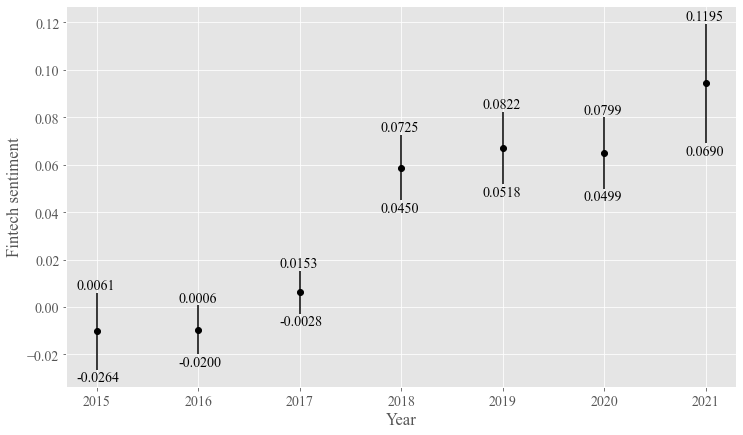

In [21]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 14})

# x-axis corresponds to years and y-axis corresponds to beta coefficients
X = [2015,2016,2017,2018,2019,2020,2021]
y1 = list(results2.params)[1:-4]

# add 99.5% confidence interval bands, params is again beta coefficients
params = results2.params.to_numpy().reshape((len(results2.params),1))
# conf_int set at p=0.005 level, locate the coefficients of interest
errors = np.subtract(results2.conf_int(alpha=0.005),params).iloc[1:-4,1].to_numpy()

fig, ax = plt.subplots(figsize=(12,7))

ax.errorbar(X, y1, yerr = errors, fmt = '-o', linestyle='none', color ='k')

# Add the confidence interval values to the figure
for i in range(len(X)):
    upperb = y1[i]+errors[i]
    ax.annotate(f'{upperb:.4f}', xy=(X[i]-0.2,upperb+0.0015))
    lowerb = y1[i]-errors[i]
    ax.annotate(f'{lowerb:.4f}', xy=(X[i]-0.2,lowerb-0.005))

ax.set_xlabel('Year')
ax.set_ylabel('Fintech sentiment')

plt.savefig('Datasets/H2_visual.png')
plt.show()

### 2.1) Controlling for the tweet length

This is done because the tweet length increased in October 2018 and might affect the results. It is for verifying the robustness of the results
* Figure 15 in thesis

In [22]:
model3 = sm.GEE.from_formula('sentiment ~ replies + likes + retweets + quotes + fintech_2015 + fintech_2016 + tweet_length \
                              + fintech_2017 + fintech_2018 + fintech_2019 + fintech_2020 + fintech_2021',
                            groups='username', family=famg, cov_struct=exch, data=df_train)

In [23]:
results3 = model3.fit()

In [24]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                   sentiment   No. Observations:              2837443
Model:                                 GEE   No. clusters:                   253259
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:               54499
Family:                           Gaussian   Mean cluster size:                11.2
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Sun, 16 May 2021   Scale:                           0.138
Covariance type:                    robust   Time:                         14:44:35
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0289      0.004      7.998      0.000       0.022       0.036
fintech_2015[T.True]     0.0061      0.005      1.131      0.258      -0.004       0.017
fintech_2016[T.True]     0.0072      0.004      1.937      0.053    -8.6e-05       0.014
fintech_2017[T.True]     0.0188      0.003      5.953      0.000       0.013       0.025
fintech_2018[T.True]     0.0368      0.005      8.019      0.000       0.028       0.046
fintech_2019[T.True]     0.0448      0.006      8.010      0.000       0.034       0.056
fintech_2020[T.True]     0.0406      0.006      6.268      0.000       0.028       0.053
fintech_2021[T.True]     0.0633      0.007      8.849      0.000       0.049       0.077
replies                 -0.0014      0.001     -2.734      0.006      -0.002      -0.000
likes                    0.0001   3.67e-05      3.694      0.000    6.36e-05       0.000
retweets             -7.821e-05   2.92e-05     -2.677      0.007      -0.000   -2.09e-05
quotes                   0.0006      0.001      1.062      0.288      -0.000       0.002
tweet_length             0.0010   3.08e-05     31.871      0.000       0.001       0.001
==============================================================================
Skew:                         -0.2853   Kurtosis:                       0.0333
Centered skew:                -0.1628   Centered kurtosis:              0.6392
==============================================================================
"""

In [25]:
results3.save('Datasets/H2_summary_robust.pickle')

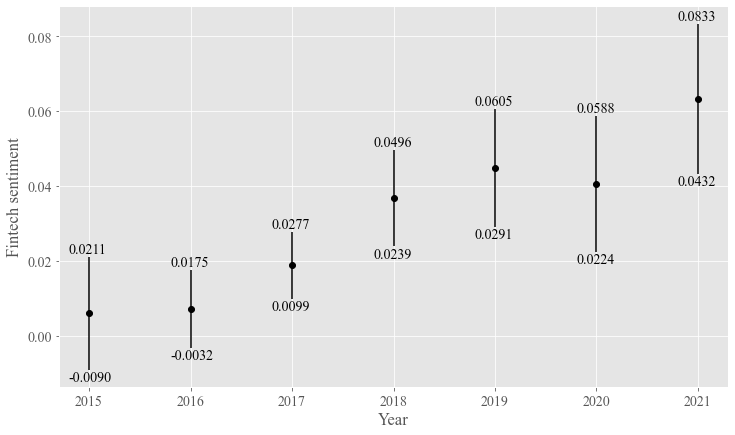

In [26]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 14})

# x-axis corresponds to years and y-axis corresponds to beta coefficients
X = [2015,2016,2017,2018,2019,2020,2021]
y1 = list(results3.params)[1:-5]

# add 99.5% confidence interval bands, params is again beta coefficients
params = results3.params.to_numpy().reshape((len(results3.params),1))
# conf_int set at p=0.005 level, locate the coefficients of interest
errors = np.subtract(results3.conf_int(alpha=0.005),params).iloc[1:-5,1].to_numpy()

fig, ax = plt.subplots(figsize=(12,7))

ax.errorbar(X, y1, yerr = errors, fmt = '-o', linestyle='none', color ='k')

for i in range(len(X)):
    upperb = y1[i]+errors[i]
    ax.annotate(f'{upperb:.4f}', xy=(X[i]-0.2,upperb+0.001))
    lowerb = y1[i]-errors[i]
    ax.annotate(f'{lowerb:.4f}', xy=(X[i]-0.2,lowerb-0.003))

ax.set_xlabel('Year')
ax.set_ylabel('Fintech sentiment')

plt.savefig('Datasets/H2_visual_robust.png')
plt.show()